In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import KFold

In [2]:
beer_data_df = pd.read_pickle(r'beer_data_df')

In [3]:
beer_data_df.head()

,rating,num_ratings,num_reviews,abv_percent,cal_per_355_ml,served_in_lager_glass,served_in_thistle,served_in_flute,served_in_masu,served_in_english_pint,...,location_ Switzerland,location_ United States,location_ Wales,overall_style_Belgian-Style Ales,"overall_style_Cider, Mead, Sake",overall_style_Lagers,overall_style_Other Styles,overall_style_Sour Beer,overall_style_Stout and Porter,overall_style_Wheat Beer
0,3.99,22,20,8.8,264.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4.13,7,7,11.1,333.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.50,1,1,6.0,180.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.51,8,6,5.0,150.0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,3.63,4,1,4.7,141.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# After EDA visualizations, note that calories and ABV are correlated & confirmed here

from scipy.stats import pearsonr

corr, _ = pearsonr(beer_data_df['cal_per_355_ml'], beer_data_df['abv_percent'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 1.000


In [5]:
beer_data_df.shape

(1260, 59)

## Split data

In [6]:
# Split data into train and test sets

X = beer_data_df.drop(columns=['rating', 'cal_per_355_ml']) # Dropping calories, correlated with ABV
y = beer_data_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=90)

## Simple linear regression

In [7]:
# Linear regression with all features

simple_model = LinearRegression()
simple_model.fit(X_train, y_train)
simple_model.score(X_train, y_train)

0.4636737922491653

In [8]:
# Cross validation with KFolds

kf = KFold(n_splits=5, shuffle=True, random_state=90)
print(cross_val_score(simple_model, X_train, y_train, cv=kf, scoring='r2'))
print(np.mean(cross_val_score(simple_model, X_train, y_train, cv=kf, scoring='r2')))

[0.35128677 0.42506074 0.36960286 0.39373137 0.36090514]
0.38011737562008385


In [9]:
# Calculating RMSE and MSE of simple_model

residuals = simple_model.predict(X_train) - y_train
rmse = np.sqrt(sum(residuals**2)/len(residuals))
print(rmse)

mae = sum(abs(simple_model.predict(X_train) - y_train))/len(y_train)
print(mae)

0.2883898647251734
0.22211586491226468


R<sup>2</sup> on the training set is higher than the validation set - overfitting! Ultimately, I will be using RMSE as my evaluation metric. First, I have to fix the issue of overfitting. There are 57 features. Let's use LassoCV for feature selection.

### Standardize data

In [10]:
# First and foremost, scale the data

std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

## LassoCV

In [11]:
# Split the training set further for cross validation within LassoCV
# Treat the validation data as "unseen" data, since I can't use test data yet

X_train_cv, X_val, y_train_cv, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=90)

In [12]:
# Let's confirm the shape of my splits...

print(f'Shape of X train = {X_train.shape}')
print(f'Shape of y train = {y_train.shape}')
print(f'Shape of X test = {X_test.shape}')
print(f'Shape of y test = {y_test.shape}')
print(f'Shape of X train data, after validation split = {X_train_cv.shape}')
print(f'Shape of y train data, after validation split = {y_train_cv.shape}')
print(f'Shape of X validation = {X_val.shape}')
print(f'Shape of y validation = {y_val.shape}')

Shape of X train = (1008, 57)
Shape of y train = (1008,)
Shape of X test = (252, 57)
Shape of y test = (252,)
Shape of X train data, after validation split = (806, 57)
Shape of y train data, after validation split = (806,)
Shape of X validation = (202, 57)
Shape of y validation = (202,)


In [13]:
# Apply the scaler to the train set
X_tr = std.transform(X_train_cv.values)

# Apply the scaler to the validation set
X_va = std.transform(X_val.values)

alphas = 10**np.linspace(-2,2,200) #.01-100
lasso_cv = LassoCV(alphas = alphas, cv = 5)
lasso_cv.fit(X_tr, y_train_cv)
r_squared_train = lasso_cv.score(X_tr, y_train_cv)
r_squared_val = lasso_cv.score(X_va, y_val)
alpha = lasso_cv.alpha_

print(r_squared_train)
print(r_squared_val)
print(alpha)
print(list(zip(X_train_cv.columns, lasso_cv.coef_)))

0.4514648274380162
0.3242717578440075
0.01
[('num_ratings', 0.0075774699318198425), ('num_reviews', 0.03709231916616569), ('abv_percent', 0.156708768408277), ('served_in_lager_glass', -0.006301891052348827), ('served_in_thistle', 0.0), ('served_in_flute', 0.017791781794639246), ('served_in_masu', -0.0005832933156881399), ('served_in_english_pint', -0.009000041864737851), ('served_in_tulip', 0.012149328914587977), ('served_in_ochoko', -0.00038415753486965344), ('served_in_kölsch_altbier', 0.0), ('served_in_bowl', 0.0), ('served_in_footed_pilsner', 0.0), ('served_in_tumbler', 0.0), ('served_in_stein', 0.008129041573203061), ('served_in_dimpled_mug', -0.0), ('served_in_guinomi', -1.1094323227872738e-06), ('served_in_weizen', -0.016782905158956498), ('served_in_yard', -0.024350224380757086), ('served_in_shaker', -0.0036308547276348423), ('served_in_snifter', 0.0), ('served_in_trappist_glass', -0.003693334989725109), ('served_in_stem_glass', 0.004124056051725159), ('days_on_site', -0.086903

In [14]:
# Calculating RMSE and MSE

residuals = lasso_cv.predict(X_tr) - y_train_cv
rmse = np.sqrt(sum(residuals**2)/len(residuals))
print(rmse)

mae = sum(abs(lasso_cv.predict(X_tr) - y_train_cv))/len(y_train)
print(mae)

0.28598282910711187
0.17679118864739252


Still looks like some major overfitting! Although, a good amount of features were dropped.

In [15]:
# How many features were dropped?

np.sum(lasso_cv.coef_ == 0)

24

In [16]:
# What features were kept in the model?
# Code credit to Alex Baransky

imp_features = sorted(list(filter(lambda tup: tup[1] != 0, zip(X_train.columns, lasso_cv.coef_))), key=lambda tup: abs(tup[1]), reverse=True)
imp_features

[('abv_percent', 0.156708768408277),
 ('days_on_site', -0.08690363548254933),
 ('overall_style_Lagers', -0.07130949816279288),
 ('location_ United States', 0.037620458091095724),
 ('num_reviews', 0.03709231916616569),
 ('location_ Russia', -0.03189790883792167),
 ('location_ Finland', -0.03093117387628547),
 ('location_ England', 0.0284630150467635),
 ('served_in_yard', -0.024350224380757086),
 ('overall_style_Cider, Mead, Sake', -0.01896124022765656),
 ('overall_style_Other Styles', -0.01886290882425707),
 ('served_in_flute', 0.017791781794639246),
 ('served_in_weizen', -0.016782905158956498),
 ('location_ France', -0.014485768694223536),
 ('served_in_tulip', 0.012149328914587977),
 ('location_ New Caledonia', -0.01070353151271639),
 ('served_in_english_pint', -0.009000041864737851),
 ('served_in_stein', 0.008129041573203061),
 ('location_ Poland', -0.007963864116424314),
 ('num_ratings', 0.0075774699318198425),
 ('served_in_lager_glass', -0.006301891052348827),
 ('served_in_stem_glas

In [17]:
# Isolate info above to name of feature only

good_features = [name for name, coef in imp_features]
good_features

['abv_percent',
 'days_on_site',
 'overall_style_Lagers',
 'location_ United States',
 'num_reviews',
 'location_ Russia',
 'location_ Finland',
 'location_ England',
 'served_in_yard',
 'overall_style_Cider, Mead, Sake',
 'overall_style_Other Styles',
 'served_in_flute',
 'served_in_weizen',
 'location_ France',
 'served_in_tulip',
 'location_ New Caledonia',
 'served_in_english_pint',
 'served_in_stein',
 'location_ Poland',
 'num_ratings',
 'served_in_lager_glass',
 'served_in_stem_glass',
 'location_ Japan',
 'served_in_trappist_glass',
 'served_in_shaker',
 'location_ Germany',
 'overall_style_Wheat Beer',
 'location_ Netherlands',
 'overall_style_Stout and Porter',
 'overall_style_Sour Beer',
 'served_in_masu',
 'served_in_ochoko',
 'served_in_guinomi']

## Lasso regression - with feature selection!

In [18]:
# Let's refit a lasso regression with the "good" features only

lasso = Lasso(alpha=0.01) # 0.01 determined from LassoCV
lasso.fit(X_train[good_features], y_train)
lasso.score(X_train[good_features], y_train)

0.35278667160778054

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=90)
print(cross_val_score(lasso, X_train[good_features], y_train, cv=kf, scoring='r2'))
print(np.mean(cross_val_score(lasso, X_train[good_features], y_train, cv=kf, scoring='r2')))

[0.27004086 0.34461754 0.34429319 0.3850373  0.28595129]
0.32598803572919344


In [20]:
# Calculating RMSE and MSE of lasso regression model

residuals = lasso.predict(X_train[good_features]) - y_train
rmse = np.sqrt(sum(residuals**2)/len(residuals))
print(rmse)

mae = sum(abs(lasso.predict(X_train[good_features]) - y_train))/len(y_train)
print(mae)

0.3168029447385967
0.24049449870107145


There's less of a discrepency between train and validation data in this model, but RMSE (my chosen metric) is still higher. I'm curious to see what the "good" features look like in a regular linear regression model.

## Simple linear regression - with feature selection!

In [21]:
# Linear regression with the "good" features, determined by LassoCV

lasso_features = LinearRegression()
lasso_features.fit(X_train[good_features], y_train)
lasso_features.score(X_train[good_features], y_train)

0.4503337561238221

In [22]:
# Cross validation with KFolds

kf = KFold(n_splits=5, shuffle=True, random_state=90)
print(cross_val_score(lasso_features, X_train[good_features], y_train, cv=kf, scoring='r2'))
print(np.mean(cross_val_score(lasso_features, X_train[good_features], y_train, cv=kf, scoring='r2')))

[0.3435251  0.45268582 0.39330305 0.44029867 0.40063406]
0.4060893408705873


In [23]:
# Calculating RMSE and MSE of lasso_features model

residuals = lasso_features.predict(X_train[good_features]) - y_train
rmse = np.sqrt(sum(residuals**2)/len(residuals))
print(rmse)

mae = sum(abs(lasso_features.predict(X_train[good_features]) - y_train))/len(y_train)
print(mae)

0.29195439477222024
0.2247527545630773


Linear regression with "good" features works okay, but not great. My model is overfitting and there is a range of cross-validation scores. I'm limited by the quality of my data. To avoid over complication of the results and interpretability, I'm going to stick with this model as the final model.

## Testing the final model - lasso_features

In [24]:
# Final R^2

lasso_features.score(X_test[good_features], y_test)

0.3477633856026333

In [25]:
# Final RMSE and MSE

residuals = lasso_features.predict(X_test[good_features]) - y_test
rmse = np.sqrt(sum(residuals**2)/len(residuals))
print(rmse)

mae = sum(abs(lasso_features.predict(X_test[good_features]) - y_test))/len(y_test)
print(mae)

0.3045725846148032
0.23514365852566513


In [108]:
# Strange that most values are 3
# Looking at distribution of y, it makes sense that model predicts mostly ratings of 3
# Assign to variable for plotting, but can use .tolist() to view all

predictions = lasso_features.predict(X_test[good_features])#.tolist()

***
## Visualizations

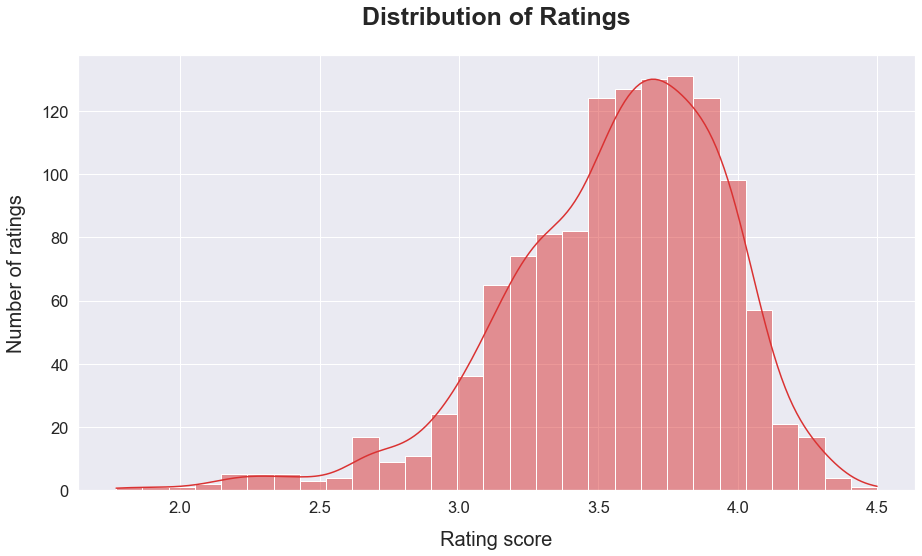

In [61]:
# Distribution of target, rating

sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 1.5)

ax = sns.histplot(data=beer_data_df, x='rating', kde=True, color="#da3232")

ax.set_xlabel(('Rating score'), fontsize=20, labelpad=15)
ax.set_ylabel(('Number of ratings'), fontsize=20, labelpad=15)
ax.text(x=0.5, y=1.06, s='Distribution of Ratings', fontsize=25, weight='bold', ha='center', va='bottom', 
        transform=ax.transAxes)

plt.savefig('distribution of ratings.png', dpi=800, bbox_inches='tight', transparent = True)

plt.show()

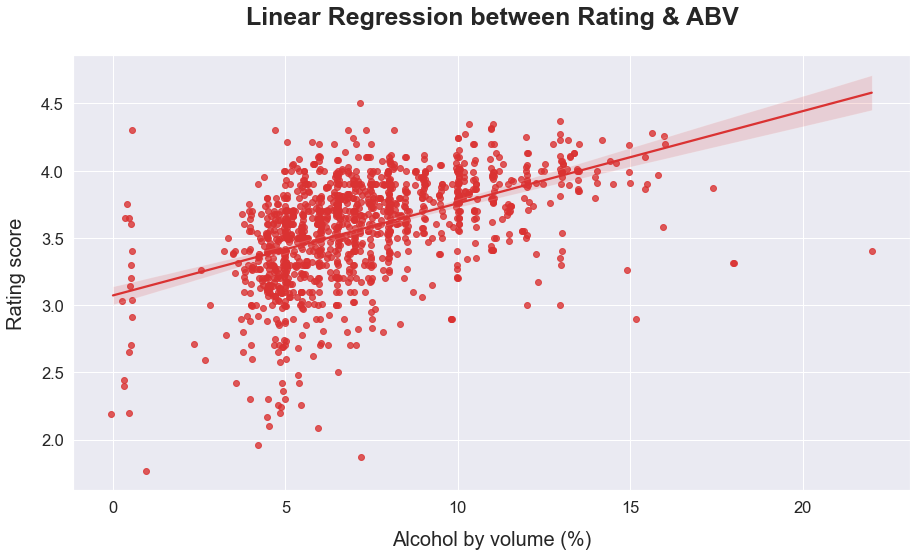

In [45]:
# Linear regression between rating & ABV

ax = sns.regplot(x='abv_percent', y='rating', data=beer_data_df, x_jitter=.05, color="#da3232")

ax.set_xlabel(('Alcohol by volume (%)'), fontsize=20, labelpad=15)
ax.set_ylabel(('Rating score'), fontsize=20, labelpad=15)
ax.text(x=0.5, y=1.06, s='Linear Regression between Rating & ABV', fontsize=25, weight='bold', ha='center', va='bottom', 
        transform=ax.transAxes)

plt.savefig('lr_rating and abv.png', dpi=800, bbox_inches='tight', transparent = True)

plt.show()

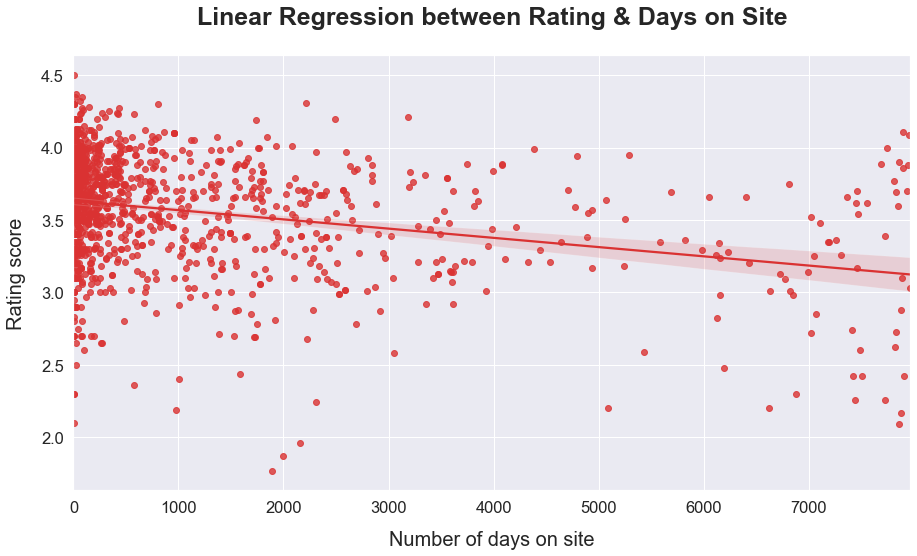

In [58]:
# Linear regression between rating & days on site

ax = sns.regplot(x='days_on_site', y='rating', data=beer_data_df, x_jitter=.05, color="#da3232")

ax.set_xlabel(('Number of days on site'), fontsize=20, labelpad=15)
ax.set_ylabel(('Rating score'), fontsize=20, labelpad=15)
ax.text(x=0.5, y=1.06, s='Linear Regression between Rating & Days on Site', fontsize=25, weight='bold', ha='center', 
        va='bottom', transform=ax.transAxes)

plt.savefig('lr_rating and days on site.png', dpi=800, bbox_inches='tight', transparent = True)

plt.show()

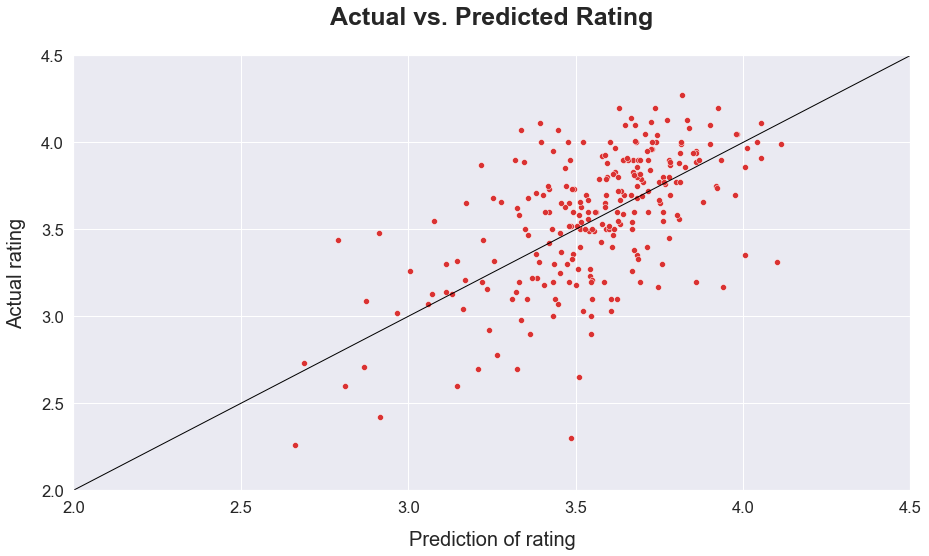

In [139]:
ax = sns.scatterplot(x=predictions, y=y_test, color="#da3232")

ax.set_xlabel(('Prediction of rating'), fontsize=20, labelpad=15)
ax.set_ylabel(('Actual rating'), fontsize=20, labelpad=15)
ax.text(x=0.5, y=1.06, s='Actual vs. Predicted Rating', fontsize=25, weight='bold', ha='center', va='bottom', 
        transform=ax.transAxes)

plt.axline((0, 0), (1, 1), linewidth=1, color='black')
plt.ylim(2, 4.5)
plt.xlim(2, 4.5)

plt.savefig('actual vs predicted rating.png', dpi=800, bbox_inches='tight', transparent = True)

plt.show()

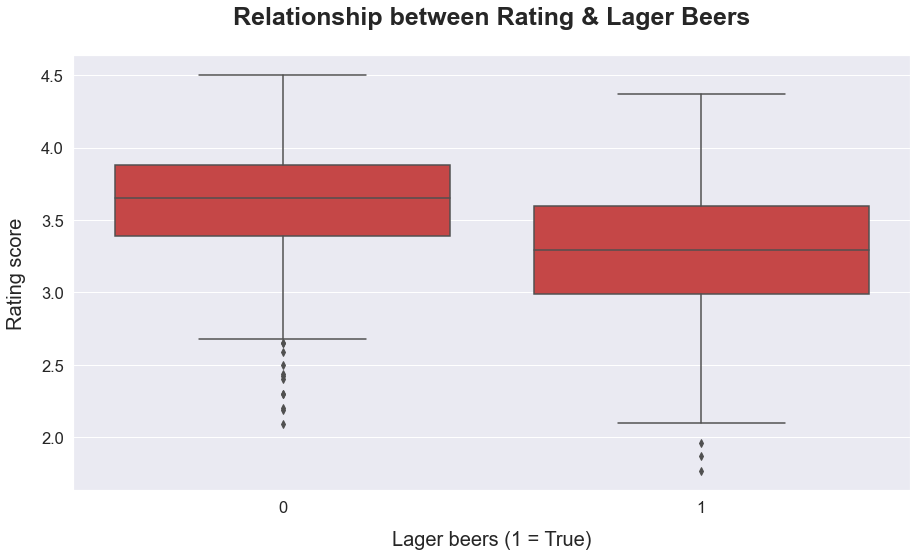

In [137]:
# Violin plot showing relationship between rating & Lager style beer

ax = sns.boxplot(x='overall_style_Lagers', y='rating', data=beer_data_df, color="#da3232")

ax.set_xlabel(('Lager beers (1 = True)'), fontsize=20, labelpad=15)
ax.set_ylabel(('Rating score'), fontsize=20, labelpad=15)
ax.text(x=0.5, y=1.06, s='Relationship between Rating & Lager Beers', fontsize=25, weight='bold', ha='center', 
        va='bottom', transform=ax.transAxes)

plt.savefig('box plot_relationship between rating and lager.png', dpi=800, bbox_inches='tight', transparent = True)

plt.show()